# KNIT7
# Creating a 4-Node Topology with L2 Networks (Auto Configuration)

## Import the FABlib Library


In [ ]:
from ipaddress import ip_address, IPv4Address, IPv4Network
import ipaddress
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
try:
    fablib = fablib_manager()
                     
    fablib.show_config()
except Exception as e:
    print(f"Exception: {e}")

## Create the Experiment Slice

The following creates four nodes, on different sites, with basic NICs connected to FABRIC's L2 Links.  

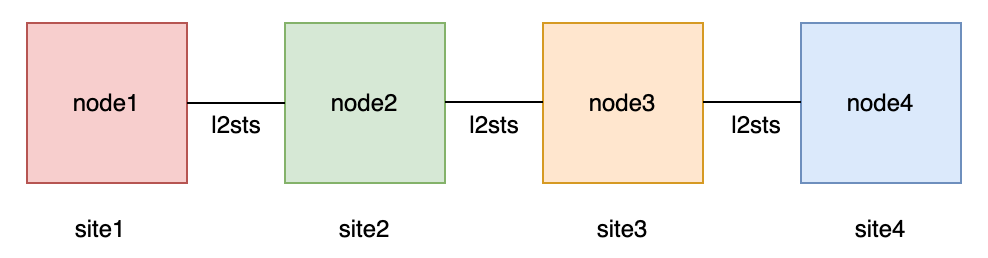

The nodes are connected to each other in a linear fashion such that node1->node2->node3->node4. Static routes are installed on node2 and node3 to allow for traffic to flow from one end to the other. Additionally IP Forwarding is enabled ion node3 and node2. All nodes are put on a random site. You can use the `fablib.get_random_site()` method with a filter for PTP Capable site to get a set of random site names that guarantee that the sites are different and PTP capable. 

In [ ]:
slice_name=f"Slice for KNIT7 Precision Timing Tutorial"
sites = []
avoid_sites = ['NCSA']
sites = fablib.get_random_sites(count=4,filter_function=lambda x:x['ptp_capable'] is True, avoid=(avoid_sites))

print (f"PTP Capable sites selected are {sites}")

node1_name = 'node1'
node2_name = 'node2'
node3_name = 'node3'
node4_name = 'node4'

network1_name='net1'
network2_name='net2'
network3_name='net3'


node1_nic12 = 'nic12'

node2_nic21 = 'nic21'
node2_nic23 = 'nic23'

node3_nic34 = 'nic34'
node3_nic32 = 'nic32'

node4_nic43 = 'nic43'

In [ ]:
try:
    #Create Slice
    slice = fablib.new_slice(name=slice_name)
    MyImage = "docker_ubuntu_22"

    # Node1
    node1 = slice.add_node(name=node1_name, site=sites[0], image=MyImage)
    
    iface12 = node1.add_component(model='NIC_Basic', name=node1_nic12).get_interfaces()[0]
    iface12.set_mode('auto')   
    
    # Node2
    node2 = slice.add_node(name=node2_name, site=sites[1],image=MyImage)

    iface21 = node2.add_component(model='NIC_Basic', name=node2_nic21).get_interfaces()[0]
    iface21.set_mode('auto')   
    iface23 = node2.add_component(model='NIC_Basic', name=node2_nic23).get_interfaces()[0]
    iface23.set_mode('auto')
    
    # Node3
    node3 = slice.add_node(name=node3_name, site=sites[2],image=MyImage)
    
    iface34 = node3.add_component(model='NIC_Basic', name=node3_nic34).get_interfaces()[0]
    iface34.set_mode('auto')   
    iface32 = node3.add_component(model='NIC_Basic', name=node3_nic32).get_interfaces()[0]
    iface32.set_mode('auto')

    # Node4
    node4 = slice.add_node(name=node4_name, site=sites[3], image=MyImage)
    
    iface43 = node4.add_component(model='NIC_Basic', name=node4_nic43).get_interfaces()[0]
    iface43.set_mode('auto')   

    # Networks
    subnet1 = IPv4Network("10.10.10.0/24")
    subnet2 = IPv4Network("10.10.20.0/24")
    subnet3 = IPv4Network("10.10.30.0/24")
    net12 = slice.add_l2network(name=network1_name, interfaces=[iface12, iface21],subnet=subnet1)
    net23 = slice.add_l2network(name=network2_name, interfaces=[iface23, iface32],subnet=subnet2)
    net34 = slice.add_l2network(name=network3_name, interfaces=[iface34, iface43],subnet=subnet3)
    
    #Submit Slice Request
    slice.submit()
except Exception as e:
    print(f"Exception: {e}")

## Observe the Slice's Attributes

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
    slice.show()
    slice.list_nodes()
    slice.list_networks()
    slice.list_interfaces()
except Exception as e:
    print(f"Exception: {e}")

## Optimize repositories based on management network type (ipv4 vs ipv6)
Since Linux Flavors have repositories on IPv4 and IPv6 mirrors, we will setup our repo mirros to use the IP version that our node uses. This enables for faster downloads by minimizing the number or mirrors to look up.

In [ ]:
nodes = slice.get_nodes()
for node in nodes:
    IPv6Management = False
    ip_proto_index = "4"
    commands = "sudo ip -6 route del default via `ip -6 route show default|grep fe80|awk '{print $3}'` > /dev/null 2>&1"
    if node.validIPAddress(node.get_management_ip()) == "IPv6":
        IPv6Management = True
        ip_proto_index = "6"
    if [ele for ele in ["rocky", "centos"] if (ele in node.get_image())]:
        commands = (
            f'sudo echo "max_parallel_downloads=10" |sudo tee -a /etc/dnf/dnf.conf;'
            f'sudo echo "fastestmirror=True" |sudo tee -a /etc/dnf/dnf.conf;'
            f'sudo echo "ip_resolve='
            + ip_proto_index
            + '" |sudo tee -a /etc/dnf/dnf.conf;'
        )
    elif [ele for ele in ["ubuntu", "debian"] if (ele in node.get_image())]:
        commands = (
            'sudo echo "Acquire::ForceIPv'
            + ip_proto_index
            + ' "true";" | sudo tee -a /etc/apt/apt.conf.d/1000-force-ipv'
            + ip_proto_index
            + "-transport"
        )
    if commands:
        stdout, stderr = node.execute(commands, quiet=True)
        print (f"Optimizing Repos for {node.get_name()}")
        #print (f"STDOUT: {stdout}")
        if stderr:
            print (f"STDERR: {stderr}")

## Testing connectivity between nodes using ping

### Get IP Addresses and Setup routes
1. Retrieve IP addresses for the interfaces
2. Enable IP Forwarding
3. Add static routes

In [ ]:
node1 = slice.get_node('node1')
node1_to_2_addr = node1.get_interface(network_name=network1_name).get_ip_addr()

node2 = slice.get_node('node2')
node2_to_1_addr = node2.get_interface(network_name=network1_name).get_ip_addr()
node2_to_3_addr = node2.get_interface(network_name=network2_name).get_ip_addr()

node3 = slice.get_node('node3')
node3_to_2_addr = node3.get_interface(network_name=network2_name).get_ip_addr()
node3_to_4_addr = node3.get_interface(network_name=network3_name).get_ip_addr()

node4 = slice.get_node('node4')
node4_to_3_addr = node4.get_interface(network_name=network3_name).get_ip_addr()

stdout, stderr = node1.execute(f"sudo echo -n '{node2_to_1_addr} node2\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node3_to_2_addr} node3\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node4_to_3_addr} node4\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo ip route add 10.10.20.0/24 via {node2_to_1_addr};\
                sudo ip route add 10.10.30.0/24 via {node2_to_1_addr};\
                echo 'Routes on Node1';\
                ip route show;\
              ")

stdout, stderr = node2.execute(f"sudo echo -n '{node1_to_2_addr} node1\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node3_to_2_addr} node3\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node4_to_3_addr} node4\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo sysctl -w net.ipv4.ip_forward=1;\
                sudo ip route add 10.10.30.0/24 via {node3_to_2_addr};\
                echo 'Routes on Node2';\
                ip route show;\
              ")

stdout, stderr = node3.execute(f"sudo echo -n '{node1_to_2_addr} node1\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node2_to_3_addr} node2\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node4_to_3_addr} node4\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo sysctl -w net.ipv4.ip_forward=1;\
                sudo ip route add 10.10.10.0/24 via {node2_to_3_addr};\
                echo 'Routes on Node3';\
                ip route show;\
                ")

stdout, stderr = node4.execute(f"sudo echo -n '{node1_to_2_addr} node1\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node2_to_3_addr} node2\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo echo -n '{node3_to_4_addr} node3\n' | sudo tee -a /etc/hosts > /dev/null ;\
                sudo ip route add 10.10.10.0/24 via {node3_to_4_addr};\
                sudo ip route add 10.10.20.0/24 via {node3_to_4_addr};\
                echo 'Routes on Node4';\
                ip route show;\
                ")


### Test path and routes using ping between each pair of nodes


In [ ]:
try:
    for src_node in nodes:
        src_name = src_node.get_name()
        for dest_node in nodes:
            dest_name = dest_node.get_name()
            if(src_name == dest_name):
                continue
            print (f"\nPinging from {src_name} to {dest_name}")
            stdout, stderr = src_node.execute(f'ping -c 5 {dest_name}')
except Exception as e:
    print(f"Exception: {e}")